# Working with Custom Images for Malaria Detection



Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 


### **Importing the Dataset**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip "/content/gdrive/My Drive/cell_images.zip"

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_251.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_261.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_41.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_54.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_57.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_85.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_104.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_109.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_128.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_142.png  
 extracting: cell_images/train/uninfected/C228ThinF_IMG_20151112_142730_cell_167.pn

### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as imread

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Setting the directory of test and train images

In [23]:
test_path = 'cell_images/test/'
train_path = 'cell_images/train/'

In [6]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [18]:
from IPython.display import clear_output

from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization ,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_size = (130, 130) #Image size

In [47]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
    rescale=1/255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=16,
    color_mode='rgb',
    class_mode='binary'
)

validation_gen = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=16,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [48]:
train_gen.class_indices   #Lables

{'parasitized': 0, 'uninfected': 1}

In [49]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="acc")
        ax2.plot(self.x, self.val_acc, label="val_acc")
        ax2.legend()
        
        plt.show()
        
        
plot = PlotLearning()

# Creating the Model

In [50]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
model.summary()  # Summary of the model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)            

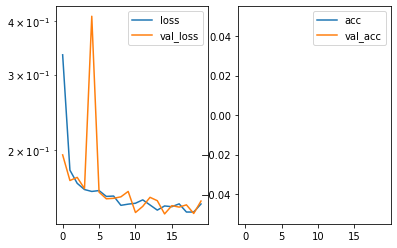

1560/1560 [==============================] - 126s 81ms/step - loss: 0.1496 - accuracy: 0.9507 - val_loss: 0.1520 - val_accuracy: 0.9531


In [52]:
model.fit_generator(train_gen, epochs=20, callbacks=[plot], validation_data=validation_gen)

In [53]:
model.save('malariaModel.h5')

In [54]:
model.evaluate_generator(validation_gen)

[0.14786918461322784, 0.9503846168518066]

In [55]:
model.metrics_names

['loss', 'accuracy']

# Predicting the cell images

In [65]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(130, 130))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving C100P61ThinF_IMG_20150918_144104_cell_34.png to C100P61ThinF_IMG_20150918_144104_cell_34 (1).png
C100P61ThinF_IMG_20150918_144104_cell_34.png
[[1.]]


In [70]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(130, 130))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=16)
  
  print(classes)
  
  if classes[0]>0:
    print(fn + " is a uninfected")
    
  else:
    print(fn + " is a parasitized")
 

Saving C184P145ThinF_IMG_20151203_104153_cell_146.png to C184P145ThinF_IMG_20151203_104153_cell_146.png
[[0.]]
C184P145ThinF_IMG_20151203_104153_cell_146.png is a parasitized


# Exporting the .tflite file

In [71]:
print (train_gen.class_indices)

labels = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'parasitized': 0, 'uninfected': 1}


# Exporting the lables.txt file

In [63]:
model.save('saved_model_dir')
converter = tensorflow.lite.TFLiteConverter.from_saved_model('saved_model_dir')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: saved_model_dir/assets


6652116